<a href="https://colab.research.google.com/github/MerkulovDaniil/split-sgd/blob/master/Code/Illustration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

 10%|█         | 2/20 [00:00<00:01, 13.21it/s]

QR finished



100%|██████████| 20/20 [00:01<00:00, 10.62it/s]


-6.81640872676738e-08


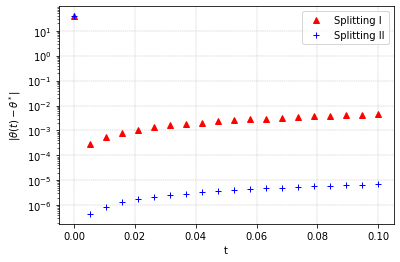

In [110]:
# ======= Libraries =======
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm, qr
import copy
from tqdm import tqdm

# ======= Function definitions =======

def generate_problem(p, n, lstsq=False):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + 1e-1*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q,R, theta_0, y_batch, h, n):
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    n, p = X.shape
    return 1/n*np.linalg.norm(X @ theta - y)**2

def gradient(X, theta, y):
    n, p = X.shape
    return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, h):
    theta = theta_0 - h*gradient(X_batch, theta_0, y_batch)
    return theta

def relative_error(theta, thetalstsq=0):
    p = len(theta)
    if np.linalg.norm(thetalstsq) != 0:
        return(np.linalg.norm(theta - thetalstsq)/np.linalg.norm(thetalstsq))
    else:
        return(np.linalg.norm(theta - np.ones(p))/np.linalg.norm(np.ones(p)))

def logarithmic_norm(A):
    w,v = np.linalg.eig((A + A.T)/2)
    return(max(w))


# ======= Problem generation =======

hs = np.logspace(-2, -1, 12)
p = 300
n = 300
s = 20
b = 15
n_max_iter = 2000
epsilon = 0.01
n_experiments = 30

X, theta_0, y, theta_lstsq = generate_problem(p,n, lstsq=True)

Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')

h = 5e-3
total_time = 1e-1
repetitions = int(total_time // h)
ts = [h for i in range(repetitions)]
theta_0     = np.random.randn(p)
theta_t     = theta_0
theta_spl_t = theta_0
theta_spl_2_t = theta_0
par_residuals_true = []
par_residuals_spl = []
par_residuals_spl_2 = []
par_residuals_true.append(np.linalg.norm(theta_t     - theta_lstsq))
par_residuals_spl.append(np.linalg.norm(theta_spl_t - theta_lstsq))
par_residuals_spl_2.append(np.linalg.norm(theta_spl_2_t - theta_lstsq))
total_time = 0
theta_con = (np.eye(p) - Q@Q.T)@theta_0 + theta_lstsq

# n = 1

for t in tqdm(ts):
    total_time += t
    # Exact solution
    theta_t = solve_local_problem(Q,R, theta_0, y, total_time, n)
    
    # First order splitting
    for i_batch in range(s):
        theta_spl_t = solve_local_problem(Qs[i_batch],Rs[i_batch], theta_spl_t, ys[i_batch], t, n)
    # Second order splitting
    for i_batch in range(s-1):
        theta_spl_2_t = solve_local_problem(Qs[i_batch],Rs[i_batch], theta_spl_2_t, ys[i_batch], t/2, n)
    theta_spl_2_t = solve_local_problem(Qs[s-1],Rs[s-1], theta_spl_2_t, ys[s-1], t, n)
    for j_batch in range(s-1):
        i_batch = s - (j_batch + 2) 
        theta_spl_2_t = solve_local_problem(Qs[i_batch],Rs[i_batch], theta_spl_2_t, ys[i_batch], t/2, n)
    par_residuals_spl.append(np.linalg.norm(theta_spl_t - theta_t))
    par_residuals_spl_2.append(np.linalg.norm(theta_spl_2_t - theta_t))
    



plt.figure(figsize=(6.0, 4.0))
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'go', label = 'True')
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'g')
plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_spl[:-1], 'r^', label = 'Splitting I')
plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_spl_2[:-1], 'b+', label = 'Splitting II')
plt.grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
plt.xlabel('t')
plt.ylabel(r'$\|\theta(t) - \theta^*\|$')
plt.legend()
print(logarithmic_norm(-1/n*R@R.T))

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('convergence_lls.pdf')
plt.show()

In [67]:
par_residuals_true

[24.726931195307603,
 0.1515608233427184,
 0.06180595496646619,
 0.025204244692517457,
 0.010278199742890442,
 0.004191412647593092,
 0.0017092429048822647,
 0.0006970230693559929,
 0.00028424348486235854,
 0.00011591346465279978,
 4.7269091755909515e-05]

In [0]:
# Archive code
steps_spl = np.average(steps_spl_meta, axis = 0)  
steps_sgd = np.average(steps_sgd_meta, axis = 0) 
times_spl = np.average(times_spl_meta, axis = 0) 
times_sgd = np.average(times_sgd_meta, axis = 0) 

plt.figure(figsize=(6.0, 4.0))
plt.title('LLS, X = ({}, {}), batch = {}, relative_tolerance = {}'.format(p, n, b, epsilon))
plt.loglog(hs, steps_spl, 'go', label = 'Splitting')
plt.loglog(hs, steps_spl, 'g:')
plt.loglog(hs, steps_sgd, 'r^', label = 'SGD')
plt.loglog(hs, steps_sgd, 'r:')
plt.grid(True,which="both", linestyle='--', linewidth=0.4)
# plt.grid()
plt.xlabel('Stepsize')
plt.ylabel('Number of steps to converge')
plt.legend()

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('sgd_split_time_lls.pdf')
plt.show()

plt.figure(figsize=(6.0, 4.0))
plt.title('LLS, X = ({}, {}), batch = {}, relative_tolerance = {}'.format(p, n, b, epsilon))
plt.loglog(hs, times_spl, 'go', label = 'Splitting')
plt.loglog(hs, times_spl, 'g:')
plt.loglog(hs, times_sgd, 'r^', label = 'SGD')
plt.loglog(hs, times_sgd, 'r:')
plt.grid(True,which="both", linestyle='--', linewidth=0.4)
plt.xlabel('Stepsize')
plt.ylabel('Time')
plt.legend()

# plt.savefig('sgd_split_step_t{}.svg'.format(epsilon))
plt.savefig('sgd_split_iterations_lls.pdf')
plt.show()


# ======= Solving problem =======

steps_spl_meta = np.zeros((n_experiments, len(hs)))
steps_sgd_meta = np.zeros((n_experiments, len(hs)))
times_spl_meta = np.zeros((n_experiments, len(hs)))
times_sgd_meta = np.zeros((n_experiments, len(hs)))

for experiment in range(n_experiments):
    print('💩 Experiment {}/{}'.format(experiment+1, n_experiments))
    theta_0 = np.random.randn(p)
    steps_spl = []
    steps_sgd = []
    times_spl = []
    times_sgd = []
    for h in hs:
        # Splitting
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while relative_error(theta) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            theta = solve_local_problem(Qs[i], Rs[i], theta, ys[i], h*N, n)
            n_iter += 1
        end_time = time.time()
        times_spl.append(end_time-start_time)
        steps_spl.append(n_iter)
        

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
        else:
            print('GGWP, splitting on {} with {} iters'.format(h, n_iter))
        

        # SGD
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while relative_error(theta) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            theta = make_SGD_step(Xs[i], theta, ys[i], h)
            if relative_error(theta) == float('Inf'):
                n_iter = n_max_iter
            n_iter += 1
        end_time = time.time()
        times_sgd.append(end_time-start_time)   
        if n_iter == n_max_iter+1:
            times_sgd[-1] = 10
        steps_sgd.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
        else:
            print('GGWP, SGD on {} with {} iters'.format(h, n_iter))

    steps_spl_meta[experiment, :] = steps_spl
    steps_sgd_meta[experiment, :] = steps_sgd
    times_spl_meta[experiment, :] = times_spl
    times_sgd_meta[experiment, :] = times_sgd                         